Per il riconoscimento facciale abbiamo bisogno di seguire i passi indicati nel paper firmato da Turk e Pentland:
- Aquisire un dataset di facce
- Calcolare le eigenfaces dal set di apprendimento conservando solo le M immagini che hanno gli autovalori più alti. Queste M facce rappresentano lo spazio delle facce, questo spazio può essere man mano aggiornato
- Calcolare la distribuzione M dimensionale per ogni individuo proiettando la faccia sullo spazio delle facce

Una volta inizializzato il sistema, possiamo procedere in questo modo:
- Calcolare un set di pesi in base all'immagine fornita e gli autovalori proiettando l'immagine su ogni eigenfaces 
- Determinare se l'immagine è effettivamente un volto controllando che sia abbastanza vicino allo spazio delle facce
- Calcolare i pesi in modo da definire se è una persona che è già segnata o meno
- Opzionalmente si possono aggiornare pesi e spazio delle facce 

In [1]:
import os
import glob 
import numpy as np
import cv2
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pickle

In [2]:
faces_xml = 'haarcascade_frontalface_alt.xml'
face_cascade = cv2.CascadeClassifier()
if not face_cascade.load(faces_xml):
    print('--(!)Errore durante il caricamento del file xml per le facce')
    exit(0)


root = "foto64x64"
cwd = os.getcwd()
listDir = os.listdir(root)
tagFoto = {}

for dir in listDir:
    imgs =  glob.glob(f"{root}/{dir}/*.jpg")
    tagFoto[dir] = imgs


In [3]:
def violajones(im):
    img = cv2.imread(im,0)
    faceROI = np.zeros((64,64), dtype=np.float32)
    faces = face_cascade.detectMultiScale(img)
    for (x, y, w, h) in faces:
        faceROI = img[y:y + h, x:x + w]
        faceROI = cv2.resize(faceROI,(64,64), interpolation=cv2.INTER_LINEAR)
        
    return faceROI

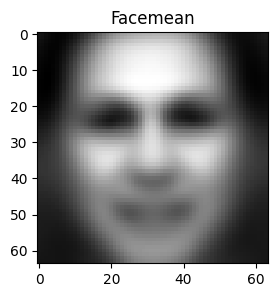

In [23]:
faceMean = np.zeros((64,64), dtype=np.float32)
faceNumber = 0
listOfArray = []
faceLabel = []

for key in tagFoto:
    for im in tagFoto[key]:
        vj = violajones(im)
        faceMean += vj
        flat = vj.flat
        listOfArray.append(flat)
        faceLabel.append(key)
        faceNumber+=1

faceMean /= faceNumber

#faceMean = faceMean.astype(np.uint8)
MatrixFlattenedImages = np.vstack(listOfArray)  
flattenFaceMean = faceMean.flatten()

fig, axes = plt.subplots(1,1,sharex=True,sharey=True,figsize=(3,3))
axes.imshow(faceMean, cmap="gray")
axes.set_title("Faccia media")
plt.show()

Decommentare solo per rifare il training del modello

In [6]:
#pca = PCA().fit(MatrixFlattenedImages)


#with open('pca.pkl', 'wb') as pickle_file:
#        pickle.dump(pca, pickle_file)

In [24]:
with open('pca.pkl', 'rb') as pickle_file:
    pca = pickle.load(pickle_file)

n_componenti = 500
eigenfaces = pca.components_[:n_componenti]
weights = eigenfaces @ (MatrixFlattenedImages - pca.mean_).T


Approssimazione migliore Kalpana_Chawla  
 Distanza euclidea 1907.826171875 


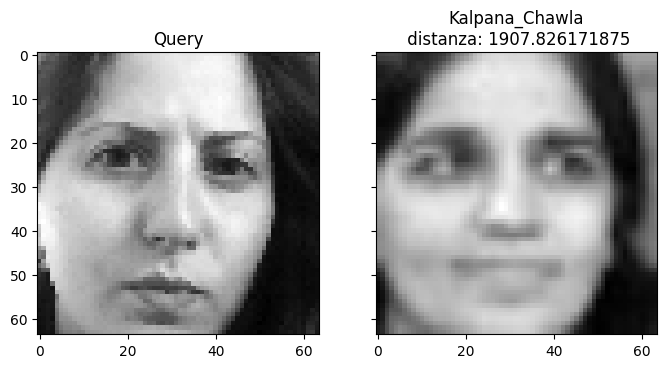

In [30]:

vj = violajones("test/0.jpg")
query = vj.reshape(1,-1)
query_weight = eigenfaces @ (query - pca.mean_).T
euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
best_match = np.argmin(euclidean_distance)
print(f"Approssimazione migliore {faceLabel[best_match]}  \n Distanza euclidea {euclidean_distance[best_match]} ")

fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
axes[0].imshow(query.reshape(64,64), cmap="gray")
axes[0].set_title("Query")
axes[1].imshow(MatrixFlattenedImages[best_match].reshape(64,64), cmap="gray")
axes[1].set_title(f"{faceLabel[best_match]}\n distanza: {euclidean_distance[best_match]}")
plt.show()


In [28]:
def violajonesMultiple(img):
    faceROI = np.zeros((64,64), dtype=np.float32)
    faces = face_cascade.detectMultiScale(img)
    listOfFaceROI = []
    pos =[]
    for (x, y, w, h) in faces:
        faceROI = img[y:y + h, x:x + w]
        faceROI = cv2.resize(faceROI,(64,64), interpolation=cv2.INTER_LINEAR)
        listOfFaceROI.append(faceROI)
        pos.append([(x, y), (x+w, y+h), (255, 0, 255), 4])
    return listOfFaceROI, pos

def findCorrespondence(frame):
    vjMul, pos = violajonesMultiple(frame)
    print(f"trovati {len(vjMul)} volti nel frame")
    for vj in vjMul:
        query = vj.reshape(1,-1)
        query_weight = eigenfaces @ (query - pca.mean_).T
        euclidean_distance = np.linalg.norm(weights - query_weight, axis=0)
        best_match = np.argmin(euclidean_distance)
        print(f"Approssimazione migliore {faceLabel[best_match]}  \n Distanza euclidea {euclidean_distance[best_match]} ")
        #fig, axes = plt.subplots(1,2,sharex=True,sharey=True,figsize=(8,6))
        #axes[0].imshow(query.reshape(64,64), cmap="gray")
        #axes[0].set_title("Query")
        #axes[1].imshow(MatrixFlattenedImages[best_match].reshape(64,64), cmap="gray")
        #axes[1].set_title(f"{faceLabel[best_match]}\n distanza: {euclidean_distance[best_match]}")
        #plt.show()
    for p in pos:
        frame = cv2.rectangle(frame, p[0],p[1],p[2],p[3])

    #cv2.imshow("face detect", frame)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()



In [29]:
img = cv2.imread("test/0.jpg",0)

findCorrespondence(img)

trovati 6 volti nel frame
Approssimazione migliore George_HW_Bush  
 Distanza euclidea 2276.895263671875 
Approssimazione migliore Spencer_Abraham  
 Distanza euclidea 2618.359375 
Approssimazione migliore Spencer_Abraham  
 Distanza euclidea 2017.36181640625 
Approssimazione migliore George_HW_Bush  
 Distanza euclidea 2273.0966796875 
Approssimazione migliore Charles_Pickering  
 Distanza euclidea 2496.593994140625 
Approssimazione migliore Michelle_Bachelet  
 Distanza euclidea 2416.634521484375 
